In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import joblib


In [ ]:
from google.colab import files

files.upload()

Saving movie_review_sentiment_analysis.csv to movie_review_sentiment_analysis.csv
Buffered data was truncated after reaching the output size limit.

In [ ]:
df = pd.read_csv("movie_review_sentiment_analysis.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1,'negative': 0})

In [ ]:
df['sentiment']

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [ ]:
df.dtypes

,0
review,object
sentiment,int64


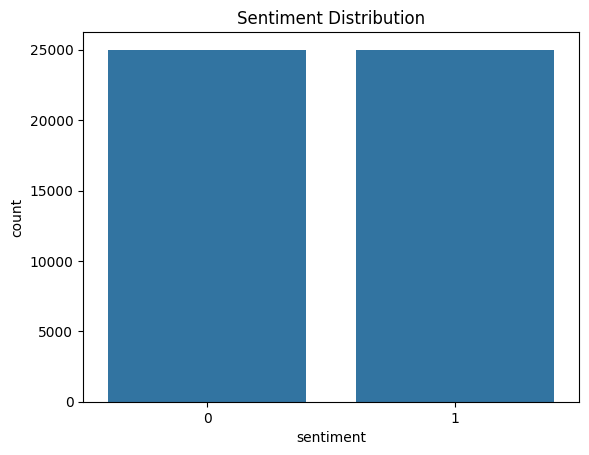

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [ ]:
df['review_length'] = df['review'].apply(len)

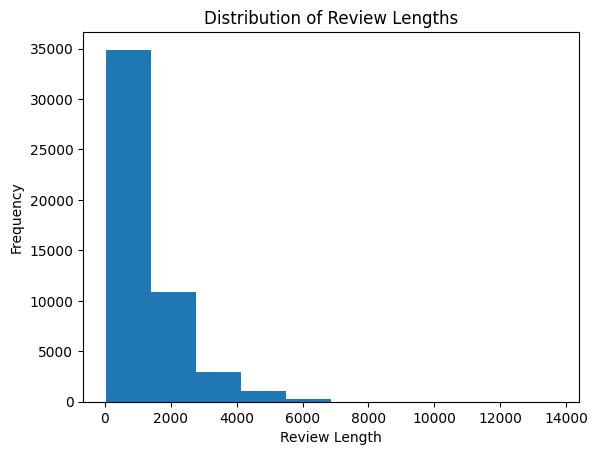

In [ ]:
plt.hist(df['review_length'])
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

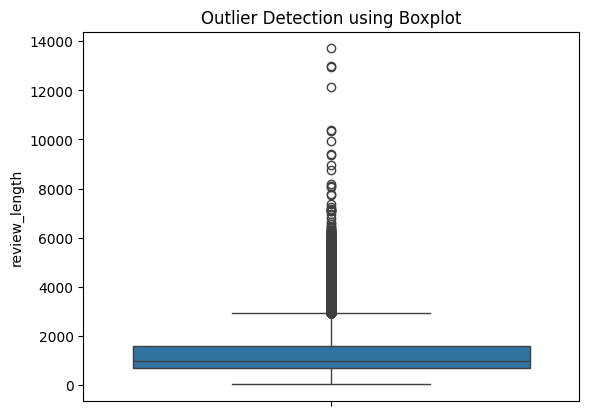

In [ ]:
sns.boxplot(df['review_length'])
plt.title("Outlier Detection using Boxplot")
plt.show()

In [ ]:
X = df['review']
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,3),
    min_df=2,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:

svm = LinearSVC(max_iter=10000)

# Filter out NaN values from y_train and corresponding X_train_tfidf
nan_mask = y_train.isna()
X_train_tfidf_cleaned = X_train_tfidf[~nan_mask.values]
y_train_cleaned = y_train[~nan_mask]

svm.fit(X_train_tfidf_cleaned, y_train_cleaned)

LinearSVC(max_iter=10000)

In [ ]:
y_pred = svm.predict(X_test_tfidf)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8812
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 5000, 10000]
}

grid = GridSearchCV(
    LinearSVC(dual=False),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Best parameters: {'C': 0.1, 'max_iter': 1000}
Best F1 score: 0.8875202519598998


In [ ]:
best_svm = grid.best_estimator_
best_svm.fit(X_train_tfidf, y_train)

LinearSVC(C=0.1, dual=False)

In [ ]:
best_pred = best_svm.predict(X_test_tfidf)

print("Optimized Accuracy:", accuracy_score(y_test, best_pred))
print(classification_report(y_test, best_pred))

Optimized Accuracy: 0.8898
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_pred = rf.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Accuracy: 0.8523


In [ ]:
manual_review = ["Not worth the price"]

manual_tfidf = tfidf.transform(manual_review)

prediction = svm.predict(manual_tfidf)

label_map = {0: "Negative", 1: "Positive"}
print("Predicted sentiment:", label_map[prediction[0]])


Predicted sentiment: Positive


In [ ]:
joblib.dump(best_svm, "svm_text_classifier.pkl")

['svm_text_classifier.pkl']

In [ ]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [ ]:
from google.colab import files

files.download('svm_text_classifier.pkl')

files.download('tfidf_vectorizer.pkl')

!ls


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

movie_review_sentiment_analysis.csv  svm_text_classifier.pkl
sample_data			     tfidf_vectorizer.pkl


In [ ]:
!zip models.zip svm_text_classifier.pkl tfidf_vectorizer.pkl



  adding: svm_text_classifier.pkl (deflated 6%)
  adding: tfidf_vectorizer.pkl (deflated 68%)


In [ ]:
!ls

models.zip			     svm_text_classifier.pkl
movie_review_sentiment_analysis.csv  tfidf_vectorizer.pkl
sample_data


In [ ]:
from google.colab import files
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
manual_review = ["Waste of money"]

manual_tfidf = tfidf.transform(manual_review)

prediction = svm.predict(manual_tfidf)

label_map = {0: "Negative", 1: "Positive"}
print("Predicted sentiment:", label_map[prediction[0]])


Predicted sentiment: Negative
